## 分析の目的とデータ読み込み

本ノートブックでは、Todo アプリからエクスポートした日次実績ログ
（daily_logs.csv）を用いて、タスク進捗の傾向および
SPI・EAC 等の指標に基づく自己調整行動の分析を行う。

以下ではまず、分析に使用するライブラリを読み込み、
実績ログデータの内容を確認する。

### 使用ライブラリの読み込み
数値計算およびデータフレーム操作に必要なライブラリを読み込む。

In [1]:
import numpy as np
import pandas as pd

### 実績ログデータの読み込みと内容確認
CSV 形式で保存した日次実績ログを読み込み、データ構造を確認する。

In [2]:
df = pd.read_csv("daily_logs.csv")
df.head()

,todoId,userId,date,minutes,estimatedMinutes,deadlineDate,createdDate,text
0,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-18,5,250,2026-03-20,2025-12-18,タイピング練習
1,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-19,10,250,2026-03-20,2025-12-18,タイピング練習
2,1fQSP4olWNYjyj9ztsIa,qEvovKzp9yTvyfV3IGR9OUERHbk1,2025-12-02,30,30,2025-12-24,2025-12-02,研究
3,53EIH4uY2PeAUhQgrVkk,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-10-16,20,240,2025-10-21,2025-10-20,中間発表の資料を完成させる
4,53EIH4uY2PeAUhQgrVkk,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-10-18,30,240,2025-10-21,2025-10-20,中間発表の資料を完成させる


### データ規模と期間の確認
分析対象となるログ件数、タスク数、および記録期間を把握する。

In [3]:
df.shape
df["todoId"].nunique()
df["date"].min(), df["date"].max()

('2025-04-08', '2025-12-22')

作業が行われていないタスク数の割合

In [4]:
(df["minutes"] == 0).mean()

np.float64(0.026881720430107527)

### 日付型変換と時系列整形
各タスクの実績ログを時系列で扱うため、日付型への変換と並び替えを行う。

In [5]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["todoId", "date"])

### 累積作業時間の算出
各タスクについて、日次作業時間を累積し、進捗量の時系列を作成する。
この日までに、どこまで進んだか

In [6]:
df["cum_minutes"] = (
    df.groupby("todoId")["minutes"]
      .cumsum()
)

### 直近7日間の平均作業ペース（pace7）の算出
短期的な作業傾向を把握するため、各タスクについて
直近7日間の平均作業時間を計算する。（一日あたり何分作業しているか）

In [7]:
df["pace7"] = (
    df.groupby("todoId")["minutes"]
      .rolling(window=7, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

### 残作業量（remaining）の算出
見積時間から累積実績を差し引き、残り作業量を算出する（負値は0に補正）。

In [8]:
df["remaining"] = df["estimatedMinutes"] - df["cum_minutes"]
df.loc[df["remaining"] < 0, "remaining"] = 0

### 締切までの残日数と必要ペース（required）の算出
締切までの残日数を求め、残作業量を日数で割って必要ペース（分/日）を算出する。
（daysLeft は 1 未満を 1 に補正する）

In [9]:
df["deadlineDate"] = pd.to_datetime(df["deadlineDate"])

df["daysLeft"] = (df["deadlineDate"] - df["date"]).dt.days
df.loc[df["daysLeft"] < 1, "daysLeft"] = 1

df["required"] = df["remaining"] / df["daysLeft"]

### SPI（進捗指数）の算出
直近7日平均の実績ペース（pace7）を必要ペース（required）で割り、
進捗状況を SPI として定量化する。

In [10]:
df["SPI"] = df["pace7"] / df["required"]

### SPI算出結果の確認
算出した SPI を、タスク別・日別に抽出し、値の妥当性を確認する。
※ remaining=0 の場合、required=0 となるため SPI は Infinity となる


In [11]:
df[["todoId", "date", "minutes", "SPI"]].head(10)

,todoId,date,minutes,SPI
0,15o0rm4pJCgfVjP6jpy1,2025-12-18,5,1.877551
1,15o0rm4pJCgfVjP6jpy1,2025-12-19,10,2.904255
2,1fQSP4olWNYjyj9ztsIa,2025-12-02,30,inf
3,53EIH4uY2PeAUhQgrVkk,2025-10-16,20,0.454545
4,53EIH4uY2PeAUhQgrVkk,2025-10-18,30,0.394737
5,53EIH4uY2PeAUhQgrVkk,2025-10-19,90,0.933333
6,53EIH4uY2PeAUhQgrVkk,2025-10-20,120,inf
7,5KxoVTiwYbl1q6tepu0D,2025-11-12,70,3.500000
8,5KxoVTiwYbl1q6tepu0D,2025-11-17,20,inf
9,5NHkI2KZn1oWspLbrLVE,2025-10-21,60,inf


### SPIに基づく進捗状態の分類

SPI を用いて、各タスク・各日の進捗状態を以下の3段階に分類する。

- SPI ≥ 1.0：良好（計画通り進行）
- 0.8 ≤ SPI < 1.0：注意（僅かな遅延）
- SPI < 0.8：遅延（重大な遅延）

この分類により、遅延の程度を段階的に捉え、
自己調整行動との関係を分析する。

In [12]:
df["state"] = np.select(
    [
        df["SPI"] >= 1.0,
        (df["SPI"] >= 0.8) & (df["SPI"] < 1.0),
        df["SPI"] < 0.8,
    ],
    [
        "ontrack",   # 計画通り
        "warning",   # 注意（僅かな遅延）
        "delay",     # 遅延（重大）
    ],
    default="unknown"
)


### SPIに基づく進捗状態の分類（3段階）
SPI の閾値（1.0 / 0.8）に基づき、各日を ontrack / warning / delay に分類し、
遅延の程度を段階的に扱えるようにする。

In [13]:
df["state"].value_counts(dropna=False)

,count
state,
ontrack,159
delay,22
warning,5


### SPI・必要ペース・進捗状態の時系列確認
算出した各指標がタスク別・日別に整合しているかを確認する。

In [14]:
df.sort_values(["todoId", "date"], inplace=True)
df[["todoId", "date", "minutes", "pace7", "required", "SPI", "state"]].head(20)

,todoId,date,minutes,pace7,required,SPI,state
0,15o0rm4pJCgfVjP6jpy1,2025-12-18,5,5.000000,2.663043,1.877551,ontrack
1,15o0rm4pJCgfVjP6jpy1,2025-12-19,10,7.500000,2.582418,2.904255,ontrack
2,1fQSP4olWNYjyj9ztsIa,2025-12-02,30,30.000000,0.000000,inf,ontrack
3,53EIH4uY2PeAUhQgrVkk,2025-10-16,20,20.000000,44.000000,0.454545,delay
4,53EIH4uY2PeAUhQgrVkk,2025-10-18,30,25.000000,63.333333,0.394737,delay
5,53EIH4uY2PeAUhQgrVkk,2025-10-19,90,46.666667,50.000000,0.933333,warning
6,53EIH4uY2PeAUhQgrVkk,2025-10-20,120,65.000000,0.000000,inf,ontrack
7,5KxoVTiwYbl1q6tepu0D,2025-11-12,70,70.000000,20.000000,3.500000,ontrack
8,5KxoVTiwYbl1q6tepu0D,2025-11-17,20,45.000000,0.000000,inf,ontrack
9,5NHkI2KZn1oWspLbrLVE,2025-10-21,60,60.000000,0.000000,inf,ontrack


### 前回値（prev_state / prev_SPI）の付与
状態遷移（ontrack→warning→delay など）を検出するため、各タスクの前回の state と SPI を付与する。

In [15]:
df["prev_state"] = df.groupby("todoId")["state"].shift(1)
df["prev_SPI"] = df.groupby("todoId")["SPI"].shift(1)

df[["todoId", "date", "prev_state", "state", "prev_SPI", "SPI"]].head(15)

,todoId,date,prev_state,state,prev_SPI,SPI
0,15o0rm4pJCgfVjP6jpy1,2025-12-18,NaN,ontrack,NaN,1.877551
1,15o0rm4pJCgfVjP6jpy1,2025-12-19,ontrack,ontrack,1.877551,2.904255
2,1fQSP4olWNYjyj9ztsIa,2025-12-02,NaN,ontrack,NaN,inf
3,53EIH4uY2PeAUhQgrVkk,2025-10-16,NaN,delay,NaN,0.454545
4,53EIH4uY2PeAUhQgrVkk,2025-10-18,delay,delay,0.454545,0.394737
5,53EIH4uY2PeAUhQgrVkk,2025-10-19,delay,warning,0.394737,0.933333
6,53EIH4uY2PeAUhQgrVkk,2025-10-20,warning,ontrack,0.933333,inf
7,5KxoVTiwYbl1q6tepu0D,2025-11-12,NaN,ontrack,NaN,3.500000
8,5KxoVTiwYbl1q6tepu0D,2025-11-17,ontrack,ontrack,3.500000,inf
9,5NHkI2KZn1oWspLbrLVE,2025-10-21,NaN,ontrack,NaN,inf


### 状態遷移イベントの定義と抽出

SPI に基づく 3 段階分類（ontrack / warning / delay）を用い，
状態が変化した日をイベントとして定義・抽出する。
具体的には，ontrack から warning への移行を「注意イベント」，
warning または ontrack から delay への移行を「遅延イベント」とし，
さらに warning を経由せずに ontrack から delay に移行したケースを
「急激な遅延イベント」として区別する。

In [16]:
warning_events = df[
    (df["prev_state"] == "ontrack") &
    (df["state"] == "warning")
]
delay_events = df[
    (df["prev_state"] != "delay") &
    (df["state"] == "delay")
]
sudden_delay_events = df[
    (df["prev_state"] == "ontrack") &
    (df["state"] == "delay")
]


In [17]:
print("warning_events:", len(warning_events))
print("delay_events:", len(delay_events))
print("sudden_delay_events:", len(sudden_delay_events))

warning_events: 3
delay_events: 10
sudden_delay_events: 2


### 回復イベントの定義

進捗状態が悪化側（delay / warning）から改善側（warning / ontrack）へ遷移した日を回復イベントとして定義する。
本研究では，delay→warning を「回復開始」，warning→ontrack を「完全回復」，
および warning 段階を経由せず delay→ontrack へ移行したケースを「急回復イベント」として区別する。

In [18]:
recovery_start_events = df[
    (df["prev_state"] == "delay") &
    (df["state"] == "warning")
]
full_recovery_events = df[
    (df["prev_state"] == "warning") &
    (df["state"] == "ontrack")
]
sudden_recovery_events = df[
    (df["prev_state"] == "delay") &
    (df["state"] == "ontrack")
]

In [19]:
print("recovery_start_events:", len(recovery_start_events))
print("full_recovery_events:", len(full_recovery_events))
print("sudden_recovery_events:", len(sudden_recovery_events))

recovery_start_events: 1
full_recovery_events: 4
sudden_recovery_events: 3


### 回復イベントにおける作業量（minutes）の記述統計
回復イベント発生日に記録された minutes の分布を確認する。

In [20]:
recovery_start_events = recovery_start_events.assign(recovery_type="start")
full_recovery_events  = full_recovery_events.assign(recovery_type="full")
sudden_recovery_events = sudden_recovery_events.assign(recovery_type="sudden")

recovery_events_all = pd.concat(
    [recovery_start_events, full_recovery_events, sudden_recovery_events],
    ignore_index=True
)

recovery_events_all.groupby("recovery_type")[["minutes"]].describe()

minutes                                                      
                count    mean        std   min     25%    50%    75%    max
recovery_type                                                              
full              4.0  137.75  92.521619  45.0  101.25  120.0  156.5  266.0
start             1.0   90.00        NaN  90.0   90.00   90.0   90.0   90.0
sudden            3.0   75.00  91.241438  15.0   22.50   30.0  105.0  180.0

### 回復イベント前後の作業量変化（minutes）
回復イベントの発生前後で作業量（minutes）が増加しているかを確認する。
各タスクの前回の minutes（prev_minutes）を付与し，
回復開始（delay→warning），完全回復（warning→ontrack），急回復（delay→ontrack）ごとに比較する。

In [21]:
# ① 先に prev_minutes を df に付与
df["prev_minutes"] = df.groupby("todoId")["minutes"].shift(1)

# ② recovery_start_events の行を df から取り直して表示（prev_minutesも確実に含まれる）
print("=== recovery_start_events (delay→warning) ===")
display(df.loc[recovery_start_events.index, ["todoId","date","prev_minutes","minutes","prev_state","state"]].dropna().head(10))

print("=== full_recovery_events (warning→ontrack) ===")
display(df.loc[full_recovery_events.index, ["todoId","date","prev_minutes","minutes","prev_state","state"]].dropna().head(10))

print("=== sudden_recovery_events (delay→ontrack) ===")
display(df.loc[sudden_recovery_events.index, ["todoId","date","prev_minutes","minutes","prev_state","state"]].dropna().head(10))


=== recovery_start_events (delay→warning) ===


,todoId,date,prev_minutes,minutes,prev_state,state
5,53EIH4uY2PeAUhQgrVkk,2025-10-19,30.0,90,delay,warning


=== full_recovery_events (warning→ontrack) ===


,todoId,date,prev_minutes,minutes,prev_state,state
6,53EIH4uY2PeAUhQgrVkk,2025-10-20,90.0,120,warning,ontrack
37,H4r4RS33SpOUYyMby8UI,2025-12-14,10.0,45,warning,ontrack
83,RzRotmx1X9OzjqCFdaCU,2025-12-10,20.0,120,warning,ontrack
85,RzRotmx1X9OzjqCFdaCU,2025-12-16,30.0,266,warning,ontrack


=== sudden_recovery_events (delay→ontrack) ===


,todoId,date,prev_minutes,minutes,prev_state,state
12,6tpDKogygJliGHVcRuhS,2025-12-17,5.0,15,delay,ontrack
53,LZcCtTroo4OcXLOZCSjS,2025-10-19,15.0,30,delay,ontrack
21,aQInLuXM80dQeHCpz6vs,2025-12-01,180.0,180,delay,ontrack


### 回復イベント前後における作業量変化
回復イベントの発生前後で作業量（minutes）の変化量（Δminutes）を算出し，
回復開始・完全回復・急回復の各ケースについて比較した。
Δminutes は当日の minutes から前回の minutes を減算することで求めた。

In [22]:
def summarize_delta(idx):
    tmp = df.loc[idx, ["prev_minutes","minutes"]].dropna(subset=["prev_minutes"]).copy()
    tmp["delta"] = tmp["minutes"] - tmp["prev_minutes"]
    return tmp["delta"].describe()

print("start delta:\n", summarize_delta(recovery_start_events.index))
print("full  delta:\n", summarize_delta(full_recovery_events.index))
print("sudden delta:\n", summarize_delta(sudden_recovery_events.index))

start delta:
 count     1.0
mean     60.0
std       NaN
min      60.0
25%      60.0
50%      60.0
75%      60.0
max      60.0
Name: delta, dtype: float64
full  delta:
 count      4.000000
mean     100.250000
std       95.952679
min       30.000000
25%       33.750000
50%       67.500000
75%      134.000000
max      236.000000
Name: delta, dtype: float64
sudden delta:
 count     3.000000
mean      8.333333
std       7.637626
min       0.000000
25%       5.000000
50%      10.000000
75%      12.500000
max      15.000000
Name: delta, dtype: float64


In [23]:
for name, ev in [
    ("start", recovery_start_events),
    ("full", full_recovery_events),
    ("sudden", sudden_recovery_events),
]:
    tmp = df.loc[ev.index, ["prev_minutes", "minutes"]].dropna().copy()
    tmp["delta_minutes"] = tmp["minutes"] - tmp["prev_minutes"]
    print(name)
    display(tmp["delta_minutes"].describe())


start


,delta_minutes
count,1.0
mean,60.0
std,NaN
min,60.0
25%,60.0
50%,60.0
75%,60.0
max,60.0


full


,delta_minutes
count,4.000000
mean,100.250000
std,95.952679
min,30.000000
25%,33.750000
50%,67.500000
75%,134.000000
max,236.000000


sudden


,delta_minutes
count,3.000000
mean,8.333333
std,7.637626
min,0.000000
25%,5.000000
50%,10.000000
75%,12.500000
max,15.000000


In [24]:
def get_delta_minutes(ev):
    tmp = df.loc[ev.index, ["prev_minutes", "minutes"]].dropna().copy()
    return tmp["minutes"] - tmp["prev_minutes"]

/tmp/ipython-input-2076526219.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


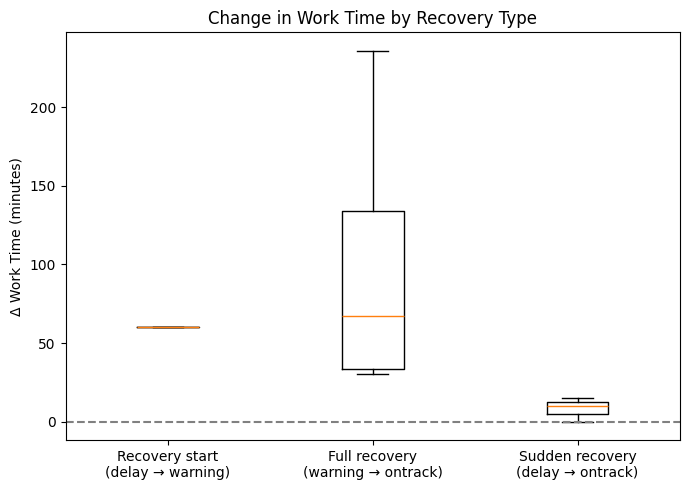

In [25]:
import matplotlib.pyplot as plt

data = [
    get_delta_minutes(recovery_start_events),   # delay → warning
    get_delta_minutes(full_recovery_events),    # warning → ontrack
    get_delta_minutes(sudden_recovery_events),  # delay → ontrack
]

labels = [
    "Recovery start\n(delay → warning)",
    "Full recovery\n(warning → ontrack)",
    "Sudden recovery\n(delay → ontrack)",
]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=labels, showfliers=True)
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Δ Work Time (minutes)")
plt.title("Change in Work Time by Recovery Type")
plt.tight_layout()
plt.show()


In [26]:
from scipy.stats import wilcoxon

def wilcoxon_before_after(event_df, before_label="Before", after_label="After"):
    tmp = df.loc[event_df.index, ["prev_minutes", "minutes"]].dropna(subset=["prev_minutes", "minutes"])
    x = tmp["prev_minutes"]
    y = tmp["minutes"]
    # Wilcoxonはペア数が少ないと不安定なので、最低2ペア以上のときだけ実行
    if len(tmp) < 2:
        return {"n": len(tmp), "stat": None, "p": None}
    stat, p = wilcoxon(x, y, zero_method="wilcox")
    return {"n": len(tmp), "stat": stat, "p": p}

results = {
    "recovery_start (delay→warning)": wilcoxon_before_after(recovery_start_events),
    "full_recovery (warning→ontrack)": wilcoxon_before_after(full_recovery_events),
    "sudden_recovery (delay→ontrack)": wilcoxon_before_after(sudden_recovery_events),
}

results


{'recovery_start (delay→warning)': {'n': 1, 'stat': None, 'p': None},
 'full_recovery (warning→ontrack)': {'n': 4,
  'stat': np.float64(0.0),
  'p': np.float64(0.125)},
 'sudden_recovery (delay→ontrack)': {'n': 3,
  'stat': np.float64(0.0),
  'p': np.float64(0.5)}}